In [1]:
# import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *
# import SVM

### Prepare the data ###

Procedure: 1. normalize coding for missing values: check each feature, assign NaN to values > 95% percentile. --> 2. check each row, drop the rows where over 50% of the features are NaN. Also remove the corresponding y  --> 3. Check each columns, drop the feature where over 50% of the rows are NaN or std == 0. Record the index for test set. --> 4. Handling NaN values: check for categorical feature (record the index), assign NaN to mean for non-categorical and majority label for categorial. --> 5. One-hot encoding for categorical data. --> 6. Standardize (skip categorical 0-1 columns)  --> 7. Regard a datapoint having more than 30% of the features with Z-score>2.5 as outliers, remove from x and corresponding y. --> 8. Data Augmentation --> 9. PCA 

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("./data/dataset_to_release", sub_sample=False)

In [3]:
print(x_train.shape)
print(y_train.shape)

(6563, 321)
(6563,)


In [4]:
# x_sub, y_sub = split_cross_validation(x_train, y_train, 10)
# np.shape(x_sub[0])

In [3]:
# thresholds for nans
row_nan = 0.6
feature_nan = 0.8
# threshold for categorical features
threshold_cat = 10
# threshold for outliers
z_threshold=2
feature_threshold=0.2

x_train_processed = x_train.copy()
y_train_processed = y_train.copy()

# transform y to 0-1 encoding
y_train_processed = process_y(y_train_processed)

# Uniform missing value encoding
# x_train_processed = normalize_nan(x_train_processed)
# Remove rows with too many nans
x_train_processed, y_train_processed = drop_rows(x_train_processed, y_train_processed, row_nan) # 0.55 remains 6101 rows
# x_train_processed.shape
# Remove features with too many nans
x_train_processed, nan_indices = drop_features(x_train_processed, feature_nan) # 0.5 remains 174 features
x_test_processed = x_test[:, nan_indices].copy()
print(x_train_processed.shape)

# get categorical feature indices
cat_indices = check_categorical(x_train_processed, threshold_cat)
# handling remaining nans
x_train_processed = fillna(x_train_processed, cat_indices)
x_test_processed = fillna(x_test_processed, cat_indices)

# One hot encoding for categorical features

x_train_processed, x_test_processed = one_hot_encoding(x_train_processed, x_test_processed, cat_indices)

x_train_processed, train_mean, train_std = standardize(x_train_processed)
x_test_processed = (x_test_processed - train_mean) / train_std
# x_train_processed, y_train_processed = z_outlier_removal(x_train_processed, y_train_processed, z_threshold, feature_threshold)
print(x_train_processed.shape)
print(y_train_processed.shape)
# x_train_processed = add_bias(x_train_processed)


(317917, 201)
(317917, 568)
(317917,)


In [4]:
x_test_processed.shape

(109379, 568)

In [6]:
np.sum(y_train_processed==1)

550

In [7]:
print(x_train_processed.shape)
print(y_train_processed.shape)
print(np.sum(x_train_processed.std(axis=0) == 0))

(6368, 586)
(6368,)
0


In [8]:
# x_train_processed_orig = x_train.copy()
# x_train_processed_orig = fillna_with_mean(x_train_processed_orig, threshold=threshold_nan)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = polynomial_expansion_single(x_train_processed_orig, degree=2)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = add_bias(x_train_processed_orig)
# # add a column of ones
# y_train_processed_orig = y_train.copy()
# y_train_processed_orig = process_y(y_train_processed_orig)
# print(np.isnan(x_train_processed_orig).any())

In [9]:
# print(x_train_processed_orig.shape)
# print(y_train_processed_orig.shape)

In [10]:
# ## PCA feature selection 
# pre_train_data = x_train_processed.copy()

# x_pca, eig_vec, eig_val,weight = pca(pre_train_data, 200)
# print(weight)

In [11]:
# x_pca.shape

In [12]:
# cummulation = np.cumsum(weight)
## cummulation
# plt.plot(cummulation)

In [13]:
# x_pca.shape

### Experiment ###

In [14]:
# ## linear regression using all the features except for those having NaN values over 50% ##
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# # x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters=500, gamma=0.01)
# y_pred = x_v @ w
# y_pred_mean = np.mean(y_pred)
# y_pred = (y_pred > y_pred_mean).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [15]:
# x_train_processed.shape

In [16]:
# # logistic regression using all the features except for those having NaN values over 50% ##
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=500, gamma=0.1)
# y_pred = sigmoid(x_v @ w)
# y_pred = (y_pred >= 0.7).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [17]:
# # logistic regression
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = reg_logistic_regression(y_t, x_t, lambda_=0.1, initial_w=initial_w, max_iters=500, gamma=0.15)
# y_pred = (x_v @ w >= 0.75).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [18]:
# # ridge regression using all the features except for those having NaN values over 50% ##
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# w, loss = ridge_regression(y_t, x_t, lambda_=0.01)
# y_pred = x_v @ w
# y_pred_mean = np.mean(y_pred)
# y_pred = (y_pred > y_pred_mean).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

#### Hinge loss gradient descent

In [19]:
# accs = []
# f1 = []
# for i in range(10):
#     x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.9)
#     x_t, y_t = data_augmentation(x_t, y_t)
#     initial_w = np.random.randn(x_t.shape[1]) * 0.01
#     w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.1, max_iters=500, gamma=0.01)
#     y_pred = ((x_v @ w) > 0.5).astype(int)
#     accs.append(predict_acc_pure(y_pred, y_v))
#     f1.append(predict_f1_pure(y_pred, y_v))
# print("Final accuracy score is: ", np.mean(accs))
# print("Final f1 score is: ", np.mean(f1))

In [20]:
# import sklearn.svm as svm
# cls = svm.SVC(C=50, kernel='rbf')
# x_t, y_t, x_v, y_v = split_data(x_train_processed_hinge, y_train_processed_hinge, 0.9)
# cls.fit(x_t, y_t)
# y_pred = cls.predict(x_v)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

#### PCA

In [21]:
# ## linear regression using PCA feature selection ##
# x_pca_t = add_bias(x_pca)
# x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
# # x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_pca_t.shape[1]) * 0.01
# w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters = 500, gamma=0.05)
# y_pred = x_v @ w
# y_pred_mean = np.mean(y_pred)
# y_pred = (y_pred >= y_pred_mean).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [22]:
# # logistic regression using pca feature selection #
# x_pca_t = add_bias(x_pca)
# x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_pca_t.shape[1]) * 0.01
# w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=500, gamma=0.15)
# y_pred = sigmoid(x_v @ w)
# y_pred = (y_pred >= 0.7).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [23]:
# # logistic regression using pca feature selection #
# initial_w = np.random.randn(x_pca.shape[1]) * 0.01
# w, loss = reg_logistic_regression(y_train_processed, x_pca, lambda_=0.01, initial_w=initial_w, max_iters=100, gamma=0.15)
# predict_acc(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)
# predict_f1(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)

In [24]:
# x_t, y_t, x_v, y_v = split_data(x_pca, y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.3, max_iters=500, gamma=0.01)
# y_pred = ((x_v @ w) > 1).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

### Apply SVM to classification task

In [25]:
# w_svm, b_svm = SVM.gradient_descent(x_train_processed_orig_pca[:, 1:], y_train_processed_orig, epochs=500, lr=0.3)

In [26]:
# np.shape(x_train)

### Apply Neural Network ###

In [6]:
def predict_1(network, X):
    
    # Get the final activations from forward propagation
    # a2 = forward_propagation(network, X)[-1]
    a4 = forward_propagation(network, X)[-1]
    
    # Convert activations to binary predictions (0 or 1)
    # predictions = (np.squeeze(a2) > 0.5).astype(int)
    predictions = (np.squeeze(a4) > 0.15).astype(int)
    
    return predictions

The Accuracy is: 0.8197
The F1 score is: 0.3438
The precision is: 0.2564
The recall is: 0.5217


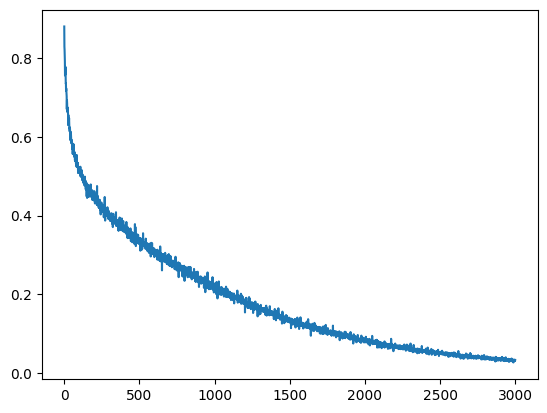

In [19]:
y_pred = predict_1(nn_trained,x_v)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)
plt.figure()
plt.plot(loss)

Epoch: 0 Loss: 0.5392757514593759 Validation F1: [0.21376574355814043, 0.2549330056478484, 0.2888721846376569, 0.3202539516313774, 0.35004847779716886, 0.37785513327929043, 0.3956433947255706, 0.373370415435425, 0.21707748876481003] Validation Acc: [0.3579202315047811, 0.5041362606945143, 0.5982794413688979, 0.673329768495219, 0.7364274031202819, 0.7948068696527428, 0.8446621791645696, 0.8866066935078007, 0.9095841721187721]
Epoch: 2 Loss: 0.427933897121662 Validation F1: [0.22568837190385166, 0.2636867127383228, 0.29552697473252904, 0.3257752255947498, 0.35531205700931007, 0.3834960397863327, 0.40464248221159455, 0.40252707581227437, 0.24768702088289718] Validation Acc: [0.40117010568696526, 0.5274597382989431, 0.6106253145445395, 0.676852667337695, 0.7353579516859587, 0.789443885254152, 0.8394564670357323, 0.8854743331655762, 0.9104806240563664]
Epoch: 4 Loss: 0.44293927947221884 Validation F1: [0.23104045398593812, 0.26907539831890603, 0.30066879906949695, 0.33107382550335573, 0.360

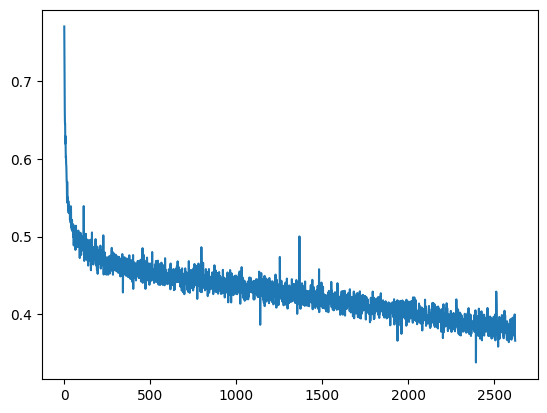

In [11]:
x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.8)
x_t, y_t = data_augmentation(x_t, y_t)
# x_t, _, _, _= pca(x_t, 100)
nn = initialize_network(input_size=np.shape(x_t)[1], hidden_size1=512, hidden_size2=128, hidden_size3=32, output_size=1)
nn_trained, loss = train(nn, x_t, y_t, x_v, y_v, learning_rate=0.05, epochs=1000, batch_size=4096)
# y_pred = predict_1(nn_trained,x_v)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)
plt.figure()
plt.plot(loss)

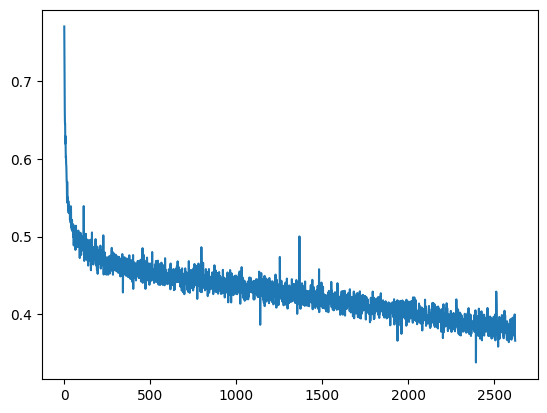

In [12]:
np.savez("./with_one_hot_deeper", network=nn_trained)
nn_trained
plt.figure()
plt.plot(loss)

In [18]:
with np.load('with_one_hot_deeper.npz', allow_pickle=True) as data:
    test_network = data.f.network
best_thre = test_network[-1]['best_threshold']
test_pred = (forward_propagation(test_network, x_test_processed)[-1].squeeze() > best_thre).astype(int)
test_pred[test_pred==0] = -1
create_csv_submission(test_ids, test_pred, 'submission_NN_deeper.csv')

In [23]:
import pandas as pd
last_pred = pd.read_csv('./submission_NN.csv')
last_pred = last_pred.to_numpy()
print(sum(test_pred==last_pred[:, 1]))
print(test_pred.shape)

99355
(109379,)


In [29]:
a2 = forward_propagation(nn_trained, x_v)[-1]
    
    
y_pred = (np.squeeze(a2) > 0).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)


The Accuracy is: 0.0000
The F1 score is: 0.1550
The precision is: 0.0840
The recall is: 1.0000


0.15496017378711077

In [30]:
y_pred = predict(nn_trained,x_v)

In [31]:
y_v.mean()

0.08398744113029827

### Test NN ### 

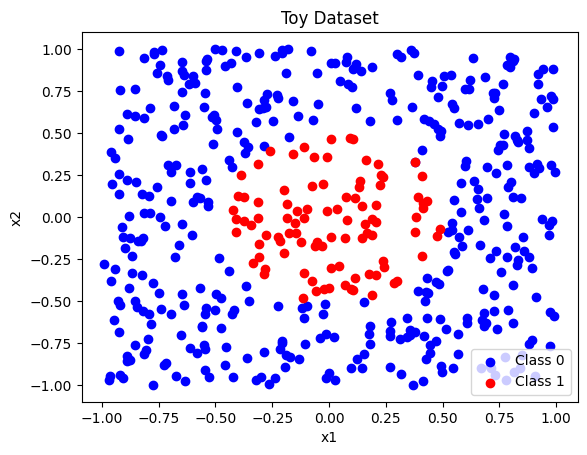

In [3]:
def generate_data(num_samples=500, radius=0.5):
    # Generate random 2D points
    x = np.random.rand(num_samples, 2) * 2 - 1 # Rescale to [-1, 1]
    
    # Create labels based on distance to the origin
    labels = (np.sum(x**2, axis=1) < radius**2).astype(int)
    
    return x, labels

x, y = generate_data()

# Visualization
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Toy Dataset')
plt.show()

In [17]:
nn = initialize_network(input_size=np.shape(x)[1], hidden_size1=5, hidden_size2=5, hidden_size3=5, output_size=1)
nn_trained = train(nn, x, y, learning_rate=0.05, epochs=100, batch_size=500)
y_pred = predict_1(nn_trained,x)
predict_acc_pure(y_pred, y)
predict_f1_pure(y_pred, y)

Epoch: 0 Loss: 0.5960713993649545
Epoch: 2 Loss: 0.5886836499733871
Epoch: 4 Loss: 0.5827500994283207
Epoch: 6 Loss: 0.577971540732857
Epoch: 8 Loss: 0.5741581619056751
Epoch: 10 Loss: 0.5710699389131818
Epoch: 12 Loss: 0.5685393714731879
Epoch: 14 Loss: 0.5664400557181418
Epoch: 16 Loss: 0.5647219149951427
Epoch: 18 Loss: 0.5632921361499584
Epoch: 20 Loss: 0.5620910896895062
Epoch: 22 Loss: 0.5610696816521645
Epoch: 24 Loss: 0.5601843390579736
Epoch: 26 Loss: 0.5594111417629322
Epoch: 28 Loss: 0.5587217542546631
Epoch: 30 Loss: 0.5581088299627553
Epoch: 32 Loss: 0.557548814646578
Epoch: 34 Loss: 0.5570304320823258
Epoch: 36 Loss: 0.5565454087525401
Epoch: 38 Loss: 0.5560847896686593
Epoch: 40 Loss: 0.555650497906715
Epoch: 42 Loss: 0.5552330608132746
Epoch: 44 Loss: 0.5548265451321599
Epoch: 46 Loss: 0.5544423285384696
Epoch: 48 Loss: 0.5540844173594669
Epoch: 50 Loss: 0.5537431878812051
Epoch: 52 Loss: 0.5534177686018374
Epoch: 54 Loss: 0.5531009190705722
Epoch: 56 Loss: 0.5527956894

0.5069637883008357

In [9]:
train(nn, x, y, learning_rate=0.01, epochs=80, batch_size=200)

Epoch: 0 Loss: 0.414994342872437
Epoch: 2 Loss: 0.5035820231674939
Epoch: 4 Loss: 0.5782620626806647
Epoch: 6 Loss: 0.5287878817649523
Epoch: 8 Loss: 0.47400353506299536
Epoch: 10 Loss: 0.49804107346850995
Epoch: 12 Loss: 0.5500767115705771
Epoch: 14 Loss: 0.636178292686436
Epoch: 16 Loss: 0.5500745275868169
Epoch: 18 Loss: 0.5866111709717188
Epoch: 20 Loss: 0.5936769386213199
Epoch: 22 Loss: 0.6496012293464288
Epoch: 24 Loss: 0.6182325285637429
Epoch: 26 Loss: 0.48896704191964907
Epoch: 28 Loss: 0.6582334949732882
Epoch: 30 Loss: 0.6022424336351448
Epoch: 32 Loss: 0.6606095435952276
Epoch: 34 Loss: 0.7345822015319613
Epoch: 36 Loss: 0.56961378619529
Epoch: 38 Loss: 0.5803986361852964
Epoch: 40 Loss: 0.5426182716456274
Epoch: 42 Loss: 0.583575646538757
Epoch: 44 Loss: 0.5367246150120908
Epoch: 46 Loss: 0.5547985365398754
Epoch: 48 Loss: 0.8424036499814465
Epoch: 50 Loss: 0.5540113910599314
Epoch: 52 Loss: 0.6610783923547345
Epoch: 54 Loss: 0.8117391898274509
Epoch: 56 Loss: 0.546776662

[{'W': array([[ 1.47262966, -0.03394927,  0.16347923, -0.66650573, -2.15848399,
          -0.69214004,  0.63075864, -0.65083722,  0.99935221,  0.72590252],
         [-1.11804858,  0.98547652, -0.28192686, -0.09143334,  0.05029914,
          -0.38101888, -2.14067348,  1.34832063,  0.0763215 , -0.24032029]]),
  'b': array([[-0.12539992,  0.05152782, -0.05364484, -0.02030469, -0.08229462,
          -0.05622815, -0.15760265,  0.02703914, -0.08570702, -0.10563057]])},
 {'W': array([[-0.4302135 ,  0.05302093, -0.48440217,  0.12345707,  0.06632657,
           0.64888332, -0.07491143,  0.21466507, -0.56201329, -1.31712724],
         [-0.24258187,  0.49316133,  0.27854052,  0.23495042, -0.4270928 ,
           0.71343097, -0.0830864 , -0.70470255, -1.26392152, -0.75422512],
         [ 0.24780896, -0.30003506, -0.13904747,  0.25294723,  0.11017984,
           0.3311965 , -0.36953454,  0.42812937,  1.02801789, -0.01297822],
         [-0.26920883,  0.32440618,  0.05934789,  0.4293773 ,  0.33375509,

In [1]:
def do_something(x):
    x["today"] = "tomorrow"

dic = {"today": "today"}
do_something(dic)
dic["today"]

'tomorrow'